In [119]:
from collections import deque
import cv2
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import time

### Create a list of vehicle and non-vehicle images from the given image datasets. Visualize randomly selected samples from each dataset. 

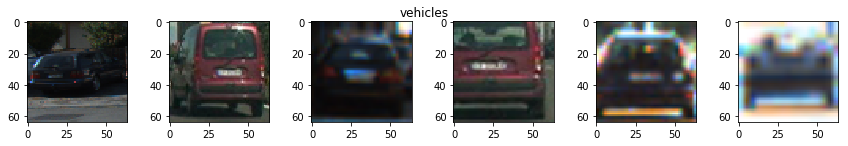

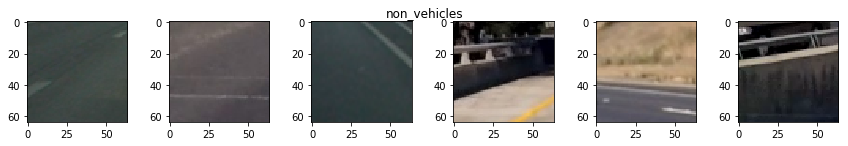

In [38]:
image_paths = glob.glob('./images/**/*.png', recursive=True)
vehicles = []
non_vehicles = []
for image_path in image_paths:
    if 'non-vehicles' in image_path:
        non_vehicles.append(image_path)
    else:
        vehicles.append(image_path)

# Convenient lists to store randomly selected samples
vehicles_samples = []
non_vehicles_samples = []
num_samples = 6
    
# Visualize few samples
def visualize_samples(image_class):
    images = eval(image_class)
    indices = np.random.randint(0, len(images), (num_samples))
    
    samples = eval(image_class + '_samples')
    
    plt_scale = 2
    pos = 1
    fig = plt.figure(figsize=(plt_scale * num_samples, plt_scale))
    fig.suptitle(image_class)

    for index in indices:
        img = mpimg.imread(images[index])
        samples.append(img)
        canvas = fig.add_subplot(1, num_samples, pos)
        plt.imshow(img)
        pos +=1
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

visualize_samples('vehicles')
visualize_samples('non_vehicles')

### Define functions useful for object detections. Most of the code is based on Lesson 20 exercises. 

#### Function for Hog Feature Extraction

In [39]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Return two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise return one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=True,
                       visualize=vis, feature_vector=feature_vec)
        return features

#### Visualize HOG features using various combinations of color spaces and HOG parameters.

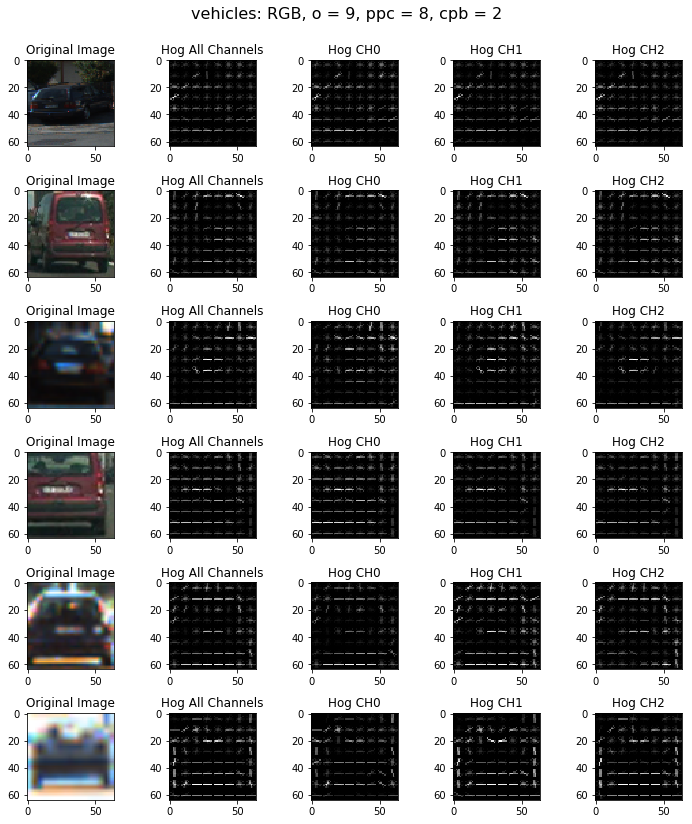

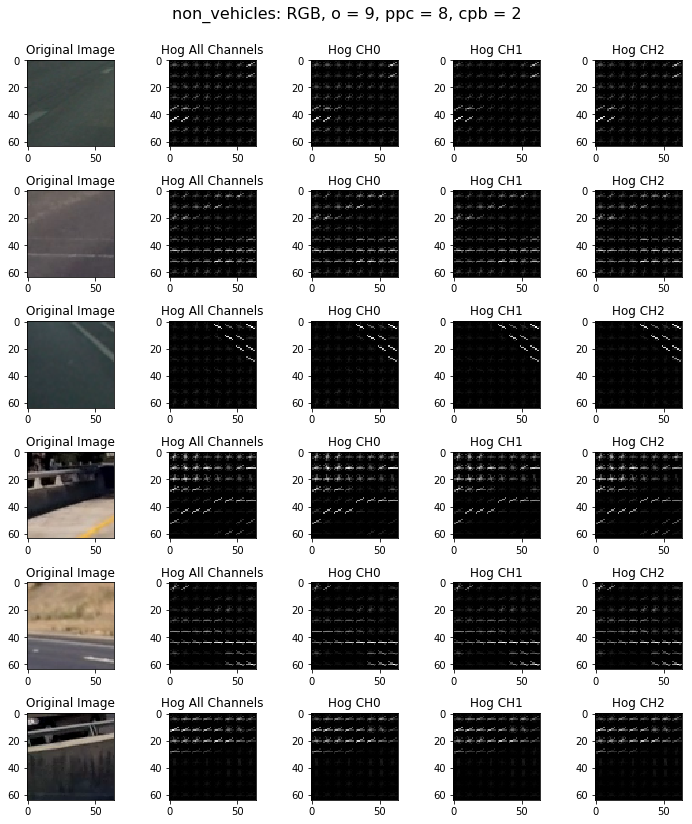

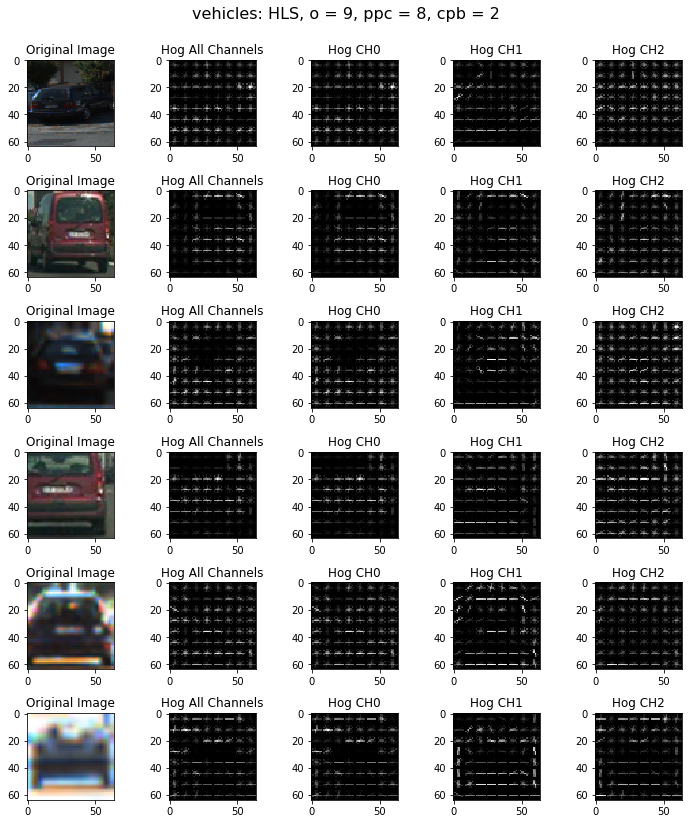

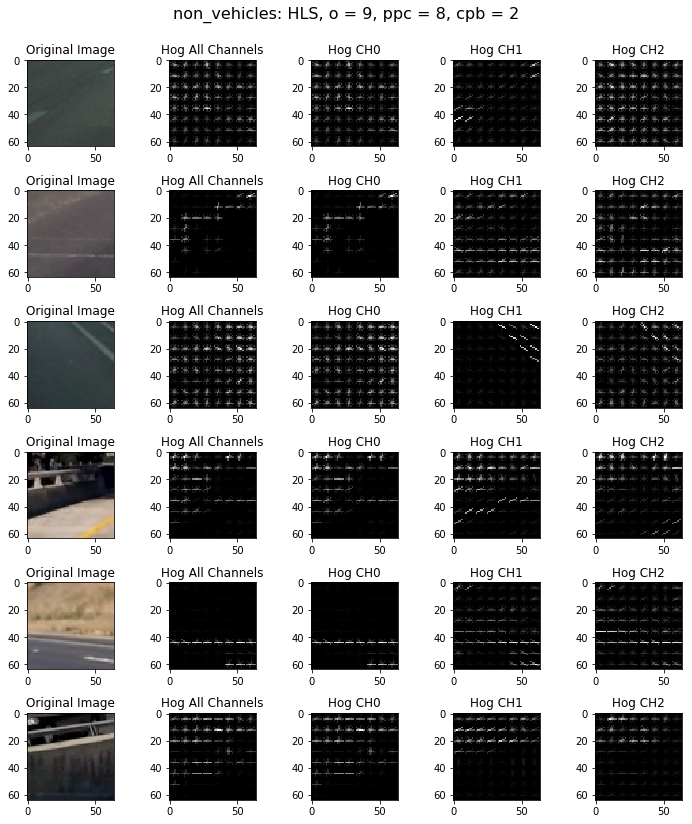

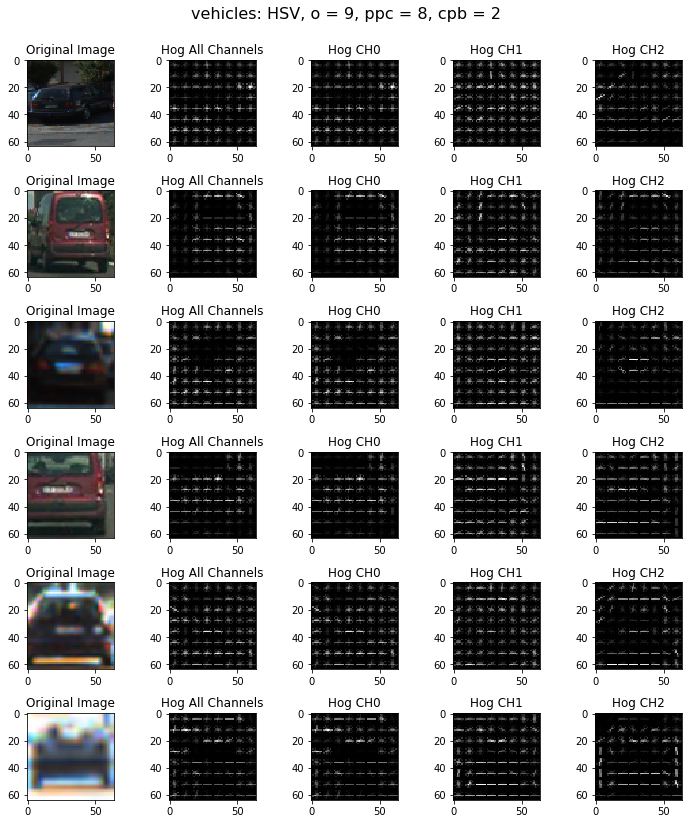

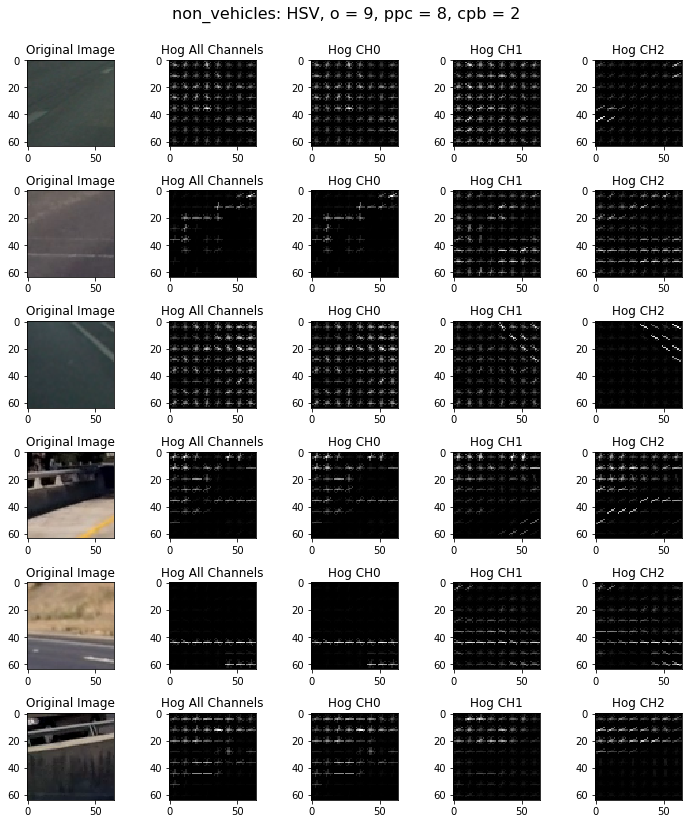

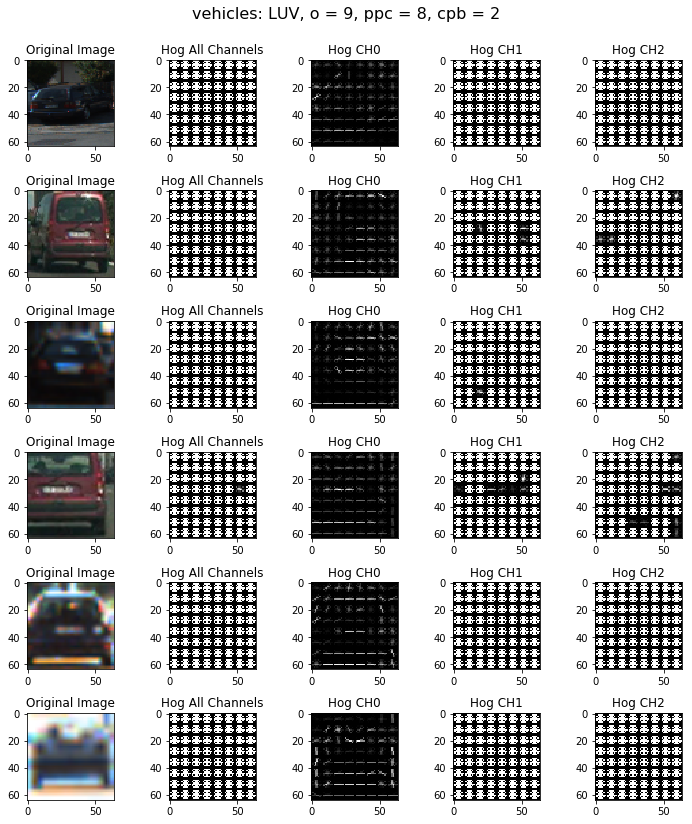

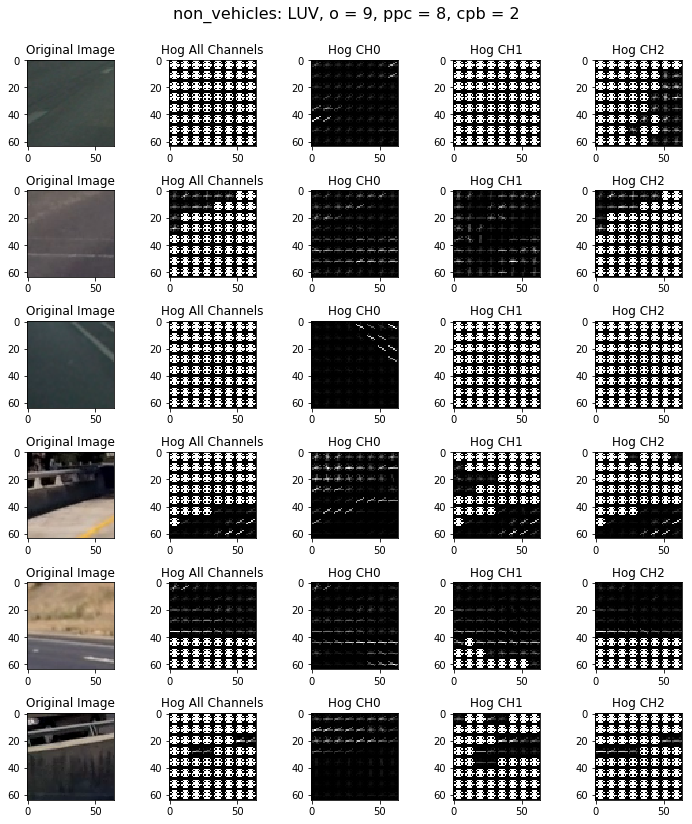

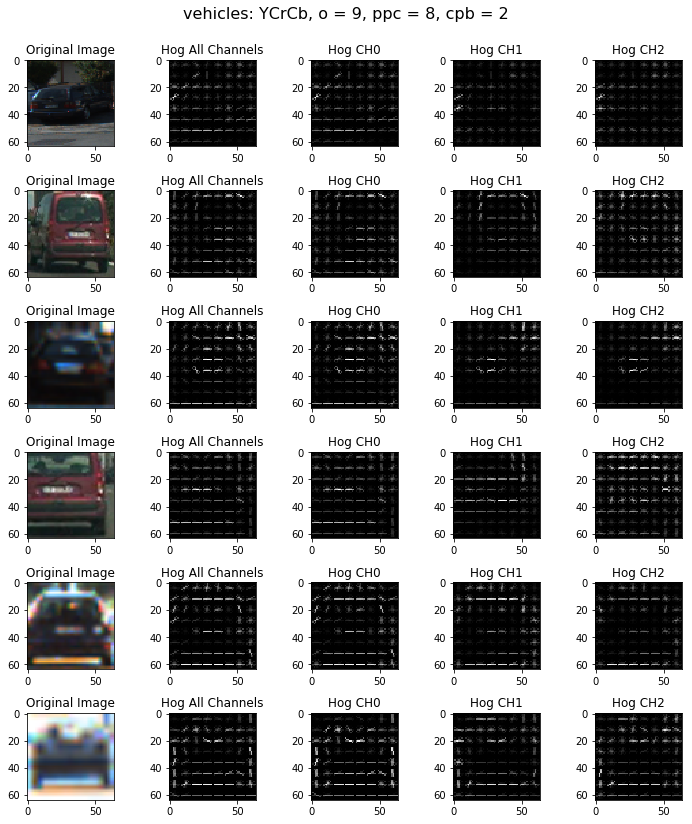

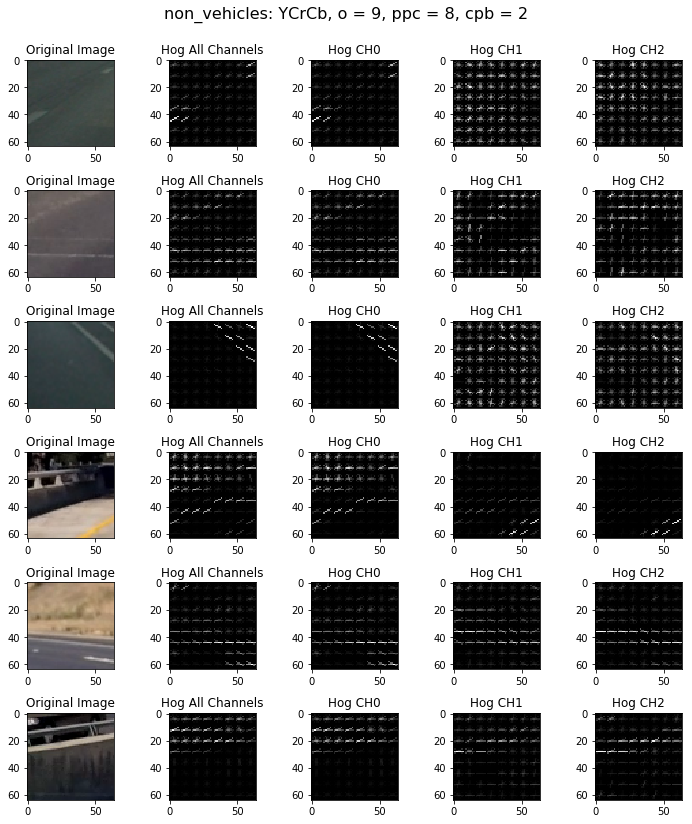

In [40]:
def visualize_hog_features1(image_class, color_space='RGB', o=9, ppc=8, cpb=2):
    samples = eval(image_class + '_samples')
    
    # Plot specs
    plt_scale = 2
    pos = 1
    fig = plt.figure(figsize=(plt_scale * 5, plt_scale * num_samples))
    title = image_class + ': ' + color_space + ', o = ' + str(o) + ', ppc = ' + str(ppc) + ', cpb = ' + str(cpb)
    fig.suptitle(title, fontsize=16)
    
    for img in samples:
        canvas = fig.add_subplot(num_samples, 5, pos)
        canvas.set_title('Original Image')
        plt.imshow(img)
        pos +=1
        cvt = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + color_space)) if color_space != 'RGB' else img
        # All channels
        hog_features, hog_img = get_hog_features(cvt, orient=o, pix_per_cell=ppc, cell_per_block=cpb, vis=True)
        canvas = fig.add_subplot(num_samples, 5, pos)
        canvas.set_title('Hog All Channels')
        plt.imshow(hog_img, cmap='gray')
        pos +=1
        for channel in range(cvt.shape[2]):
            hog_features, hog_img = get_hog_features(cvt[:,:,channel], 
                                        orient=o, pix_per_cell=ppc, cell_per_block=cpb, vis=True)
            canvas = fig.add_subplot(num_samples, 5, pos)
            canvas.set_title('Hog CH' + str(channel))
            plt.imshow(hog_img, cmap='gray')
            pos +=1
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
# To find the best color space
for color_space in ['RGB', 'HLS', 'HSV', 'LUV', 'YCrCb']:
    visualize_hog_features1('vehicles', color_space)
    visualize_hog_features1('non_vehicles', color_space)

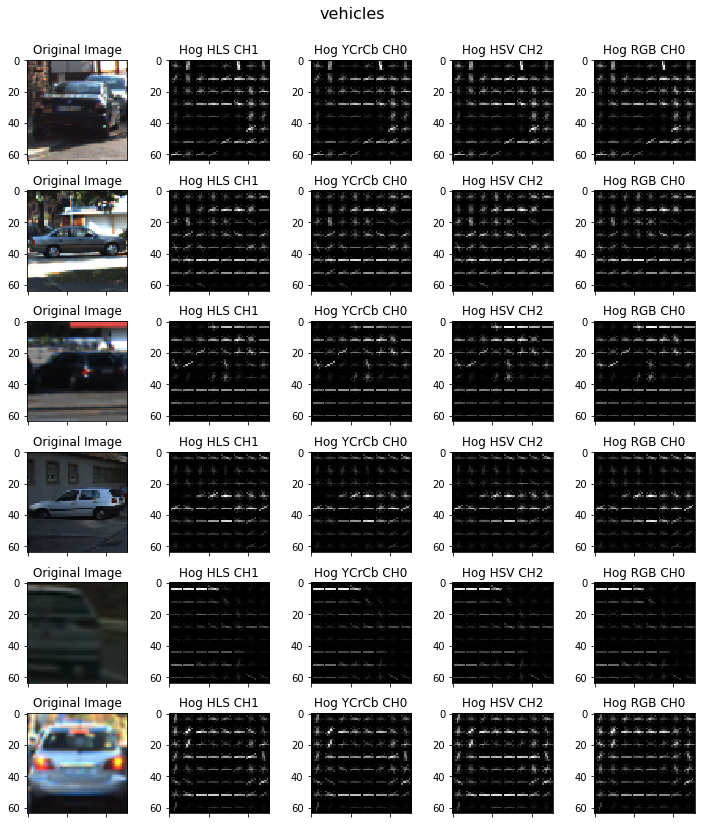

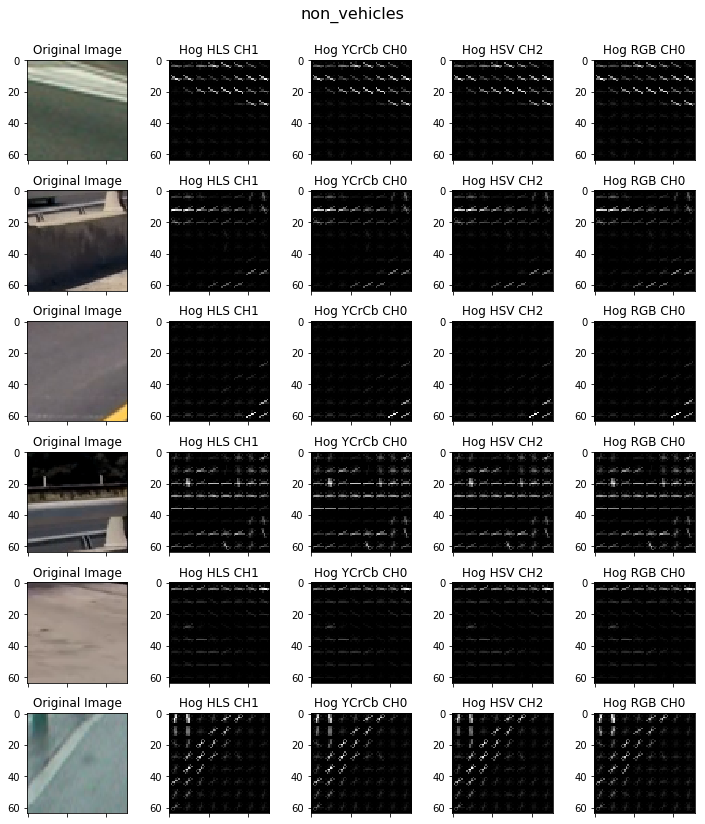

In [5]:
def visualize_hog_features2(image_class, color_spaces=['HLS', 'YCrCb'], channels=[1, 0], o=9, ppc=8, cpb=2):
    samples = eval(image_class + '_samples')
    
    # Plot specs
    plt_scale = 2
    pos = 1
    num_options = len(color_spaces) + 1
    fig = plt.figure(figsize=(plt_scale * num_options, plt_scale * num_samples))
    fig.suptitle(image_class, fontsize=16)
    fig.tight_layout()
               
    for img in samples:
        canvas = fig.add_subplot(num_samples, num_options, pos)
        canvas.set_title('Original Image')
        canvas.tick_params(axis='x', labelbottom=False)
        plt.imshow(img)
        pos +=1
        
        ch_index = 0
        for color_space in color_spaces:
            cvt = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + color_space)) if color_space != 'RGB' else img
            # Specific channel specified in the input
            hog_features, hog_img = get_hog_features(cvt[:,:,channels[ch_index]], 
                                        orient=o, pix_per_cell=ppc, cell_per_block=cpb, vis=True)
            canvas = fig.add_subplot(num_samples, num_options, pos)
            canvas.set_title('Hog ' + color_space + ' CH' + str(channels[ch_index]))
            canvas.tick_params(axis='x', labelbottom=False)
            plt.imshow(hog_img, cmap='gray')
            pos +=1
            ch_index += 1

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
visualize_hog_features2('vehicles', color_spaces=['HLS', 'YCrCb', 'HSV', 'RGB'], channels=[1, 0, 2, 0])
visualize_hog_features2('non_vehicles', color_spaces=['HLS', 'YCrCb', 'HSV', 'RGB'], channels=[1, 0, 2, 0])

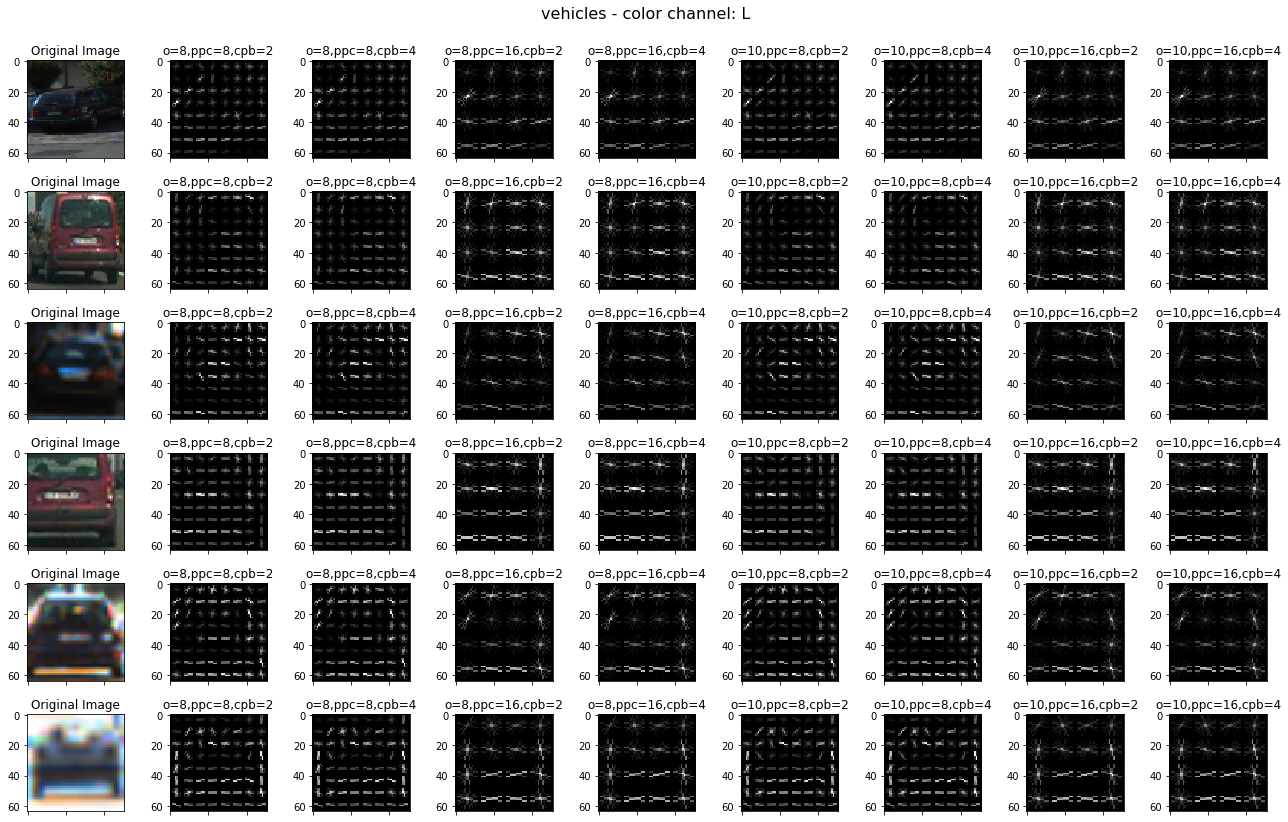

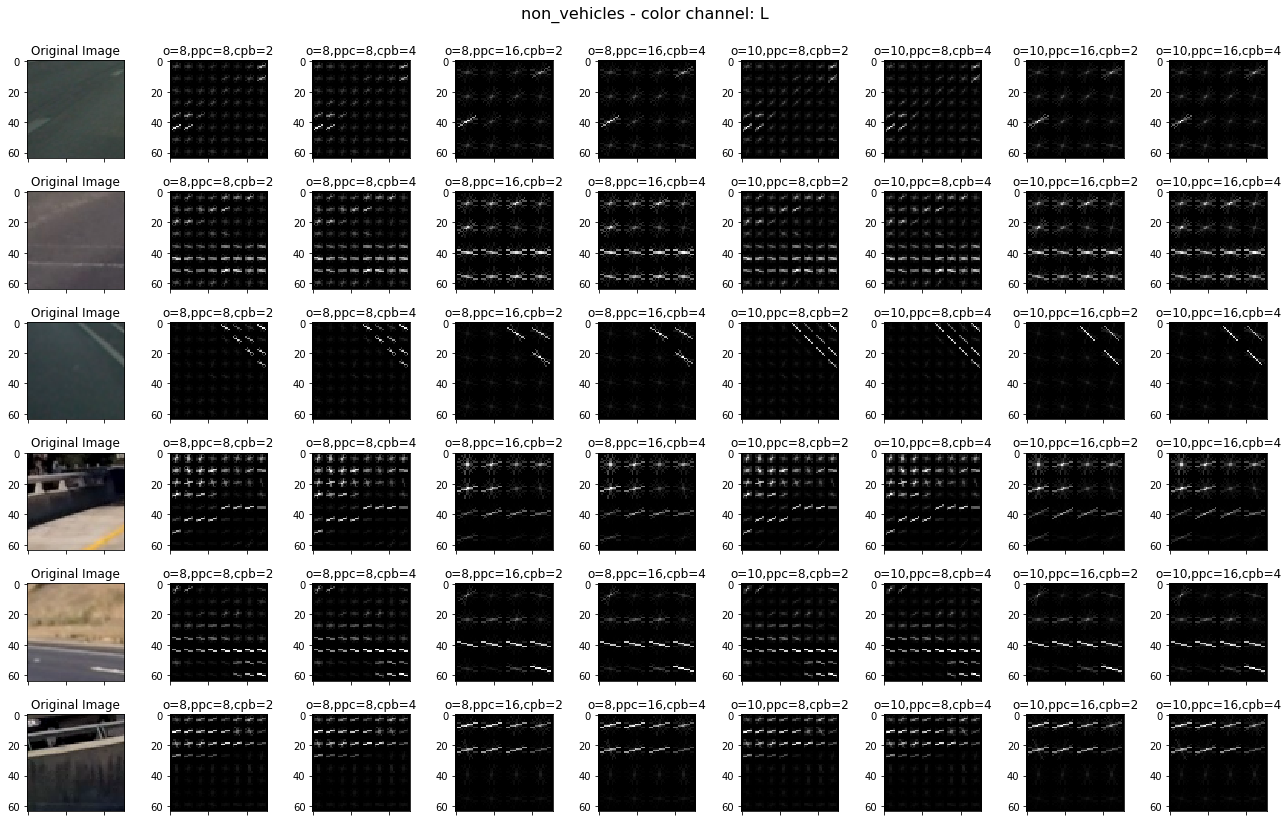

In [41]:
def visualize_hog_features3(image_class, orients=[8, 10], ppcs=[8, 16], cpbs=[2, 4]):
    samples = eval(image_class + '_samples')
    
    # Plot specs
    plt_scale = 2
    pos = 1
    num_options = len(orients) * len(ppcs) * len(cpbs) + 1
    fig = plt.figure(figsize=(plt_scale * num_options, plt_scale * num_samples))
    title = image_class + ' - color channel: L'
    fig.suptitle(title, fontsize=16)
                   
    for img in samples:
        canvas = fig.add_subplot(num_samples, num_options, pos)
        canvas.set_title('Original Image')
        canvas.tick_params(axis='x', labelbottom=False)
        plt.imshow(img)
        pos +=1
        
        ch_index = 0
        for orient in orients:
            for ppc in ppcs:
                for cpb in cpbs:
                    cvt = cv2.cvtColor(img, eval('cv2.COLOR_RGB2HLS'))
                    # Specific channel specified in the input
                    hog_features, hog_img = get_hog_features(cvt[:,:,1], 
                                                orient=orient, pix_per_cell=ppc, cell_per_block=cpb, vis=True)
                    canvas = fig.add_subplot(num_samples, num_options, pos)
                    canvas.set_title('o=' + str(orient) + ',ppc=' + str(ppc) + ',cpb=' + str(cpb))
                    canvas.tick_params(axis='x', labelbottom=False)
                    plt.imshow(hog_img, cmap='gray')
                    pos +=1
                    ch_index += 1

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
visualize_hog_features3('vehicles')
visualize_hog_features3('non_vehicles')

#### Visualize Color channels in various color spaces.

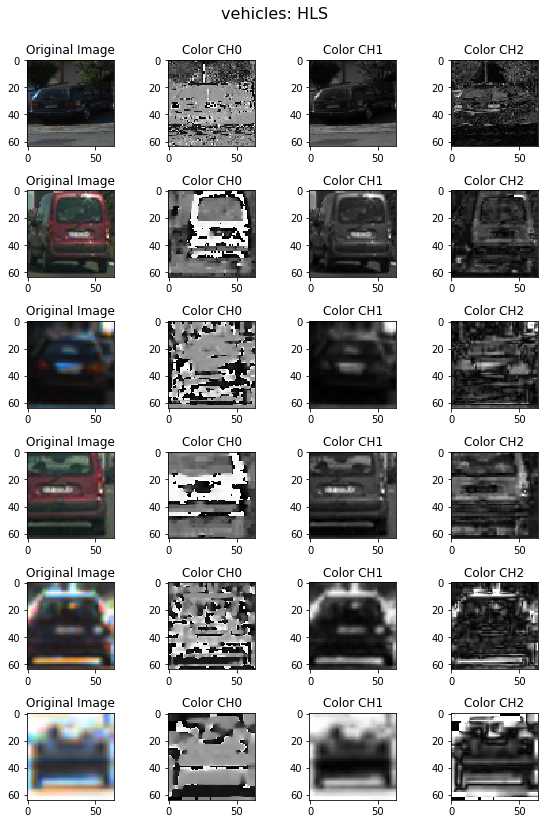

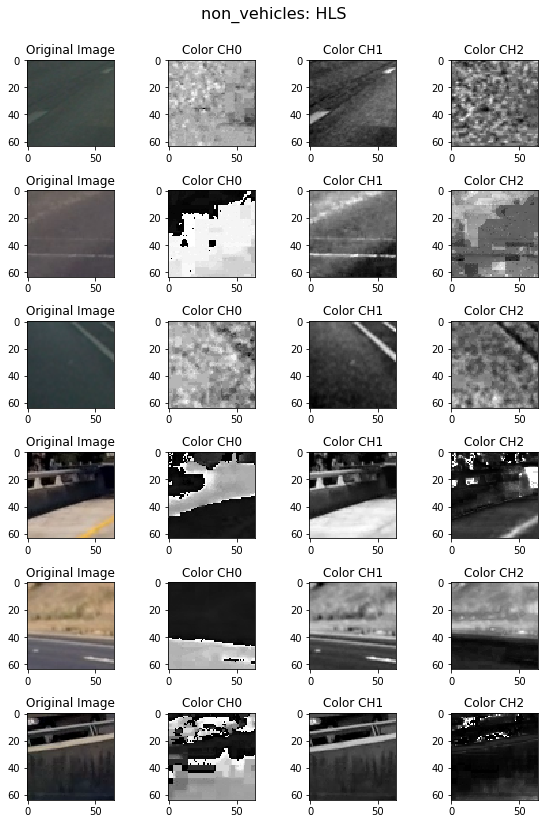

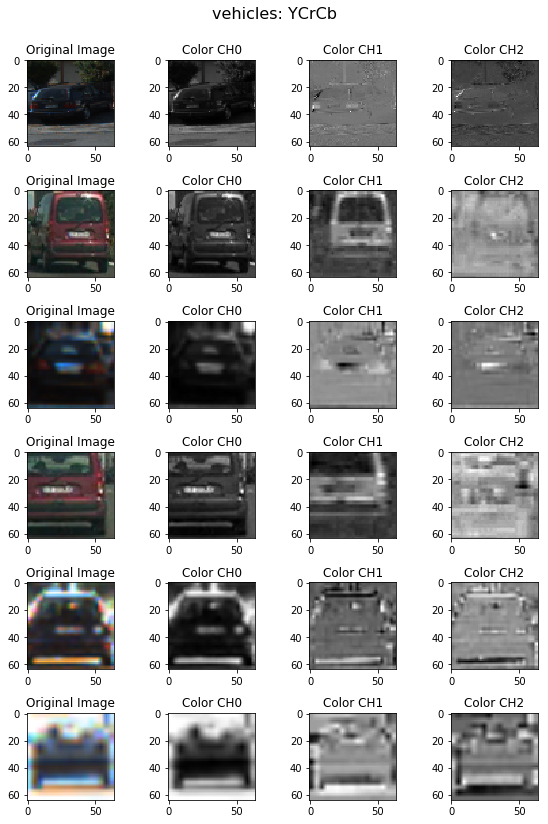

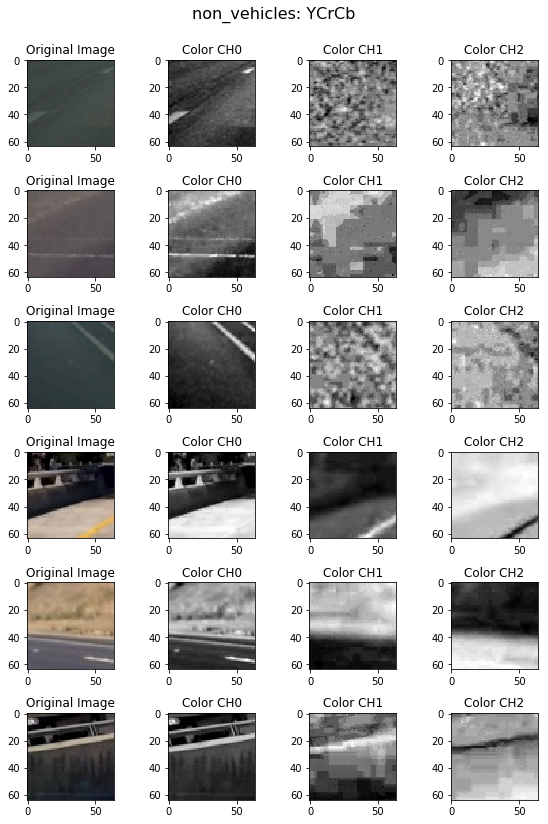

In [42]:
def visualize_color_ch_features(image_class, color_space):
    samples = eval(image_class + '_samples')
    
    # Plot specs
    plt_scale = 2
    pos = 1
    fig = plt.figure(figsize=(plt_scale * 4, plt_scale * num_samples))
    fig.suptitle(image_class + ': ' + color_space, fontsize=16)
    
    for img in samples:
        canvas = fig.add_subplot(num_samples, 4, pos)
        canvas.set_title('Original Image')
        plt.imshow(img)
        pos +=1
        cvt = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + color_space)) if color_space != 'RGB' else img
        for channel in range(cvt.shape[2]):
            canvas = fig.add_subplot(num_samples, 4, pos)
            canvas.set_title('Color CH' + str(channel))
            plt.imshow(cvt[:,:,channel], cmap='gray')
            #plt.imshow(cvt[:,:,channel])
            pos +=1
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for color_space in ['HLS', 'YCrCb']:
    visualize_color_ch_features('vehicles', color_space)
    visualize_color_ch_features('non_vehicles', color_space)

#### Functions for Spatial Bin & Color Histogram Feature Extraction

In [43]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    channels = np.array([cv2.resize(img[:,:,i], size).ravel() for i in range(3)])
    features = channels.reshape(-1,)
    # Return the feature vector
    return features, channels

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channels = np.array([np.histogram(img[:,:,i], bins=nbins, range=bins_range) for i in range(3)])
    hist_features = np.concatenate(channels[:,0])
    # Generating bin centers
    # bin_edges = channel1_hist[1]
    # bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, channels #, bin_centers

#### Visualize Color features for individual channels in various color spaces.

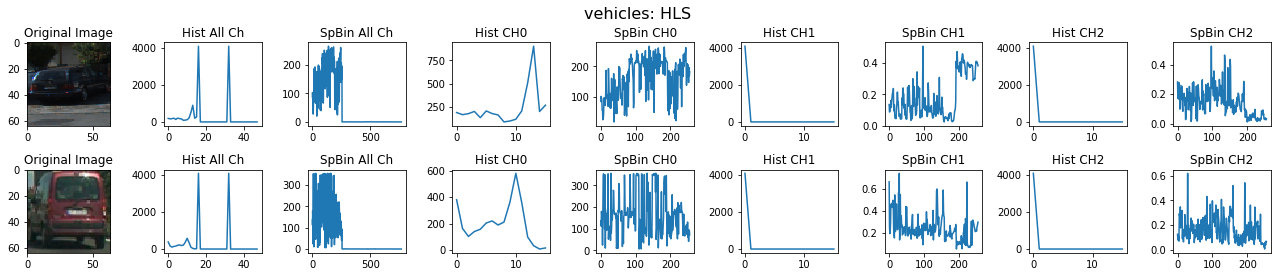

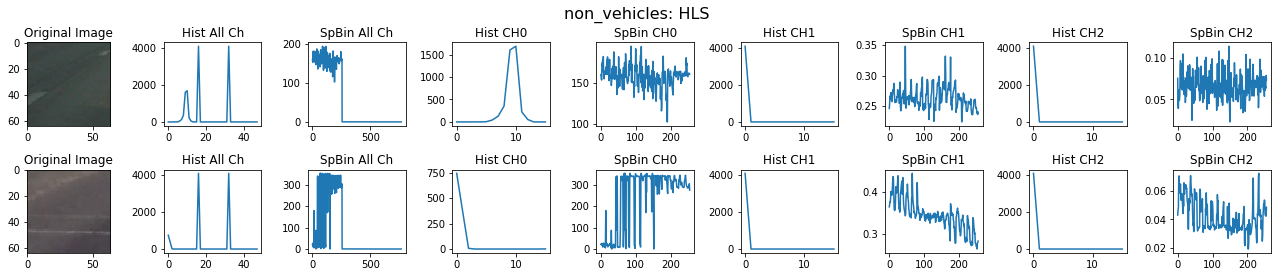

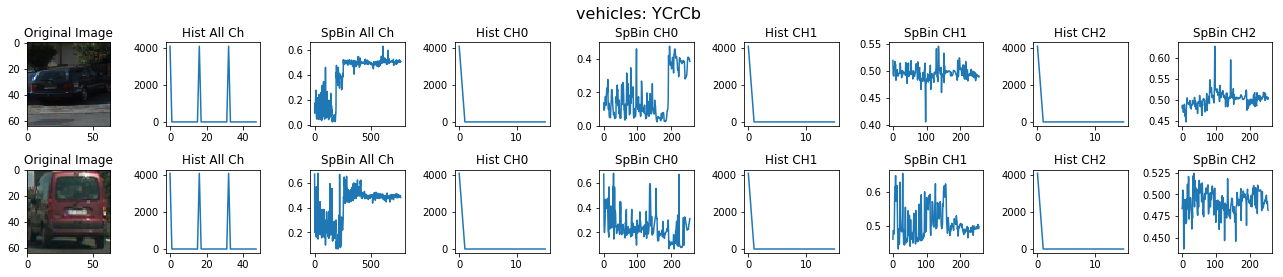

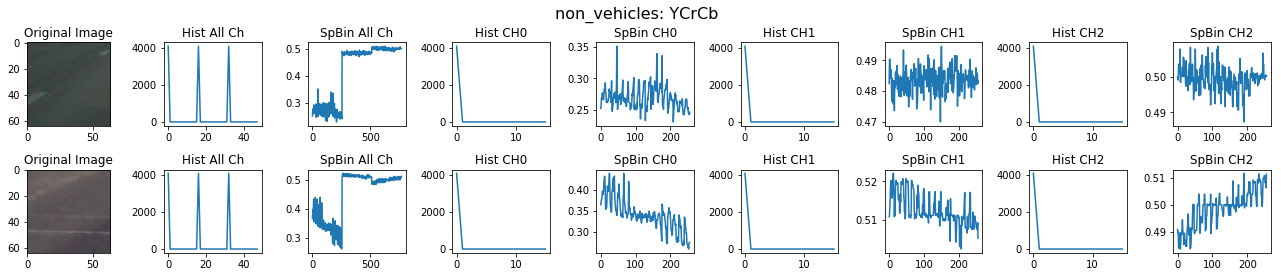

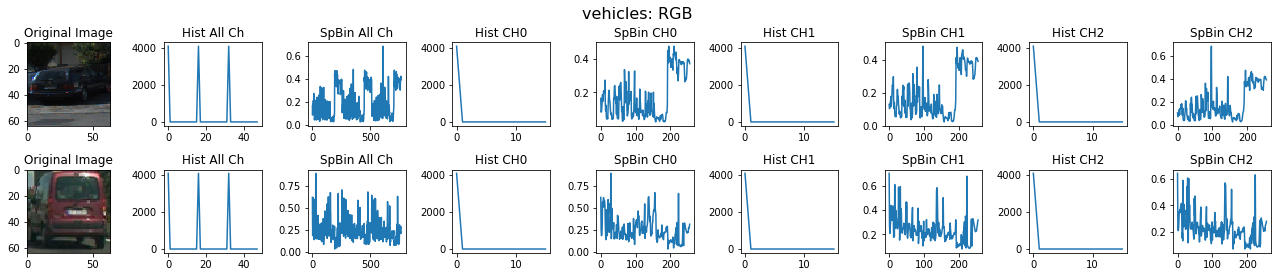

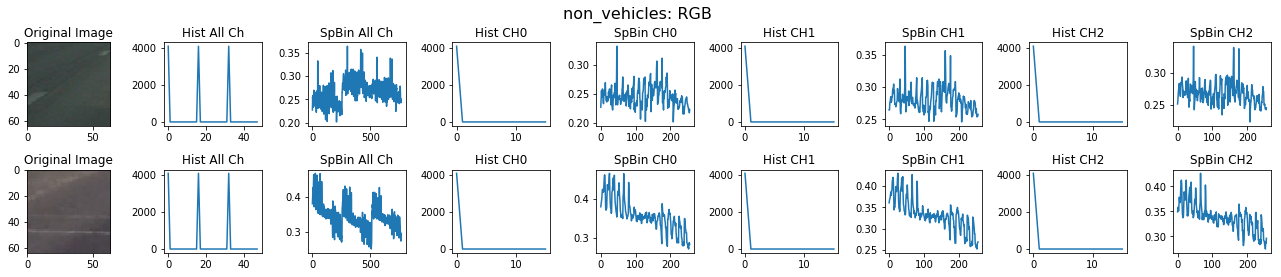

In [44]:
def visualize_color_features(image_class, color_space):
    samples = eval(image_class + '_samples')
    
    # Plot specs
    num_samples = 2
    plt_scale = 2
    pos = 1
    fig = plt.figure(figsize=(plt_scale * 9, plt_scale * num_samples))
    fig.suptitle(image_class + ': ' + color_space, fontsize=16)
    
    for img in samples[:num_samples]:
        canvas = fig.add_subplot(num_samples, 9, pos)
        canvas.set_title('Original Image')
        plt.imshow(img)
        pos +=1
        cvt = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + color_space)) if color_space != 'RGB' else img
        hist_features, hist_channels = color_hist(cvt, nbins=16)
        bin_features, bin_channels = bin_spatial(cvt, size=(16, 16))
        canvas = fig.add_subplot(num_samples, 9, pos)
        canvas.set_title('Hist All Ch')
        plt.plot(hist_features)
        pos +=1
        canvas = fig.add_subplot(num_samples, 9, pos)
        canvas.set_title('SpBin All Ch')
        plt.plot(bin_features)
        pos +=1
              
        for ch in range(3):
            canvas = fig.add_subplot(num_samples, 9, pos)
            canvas.set_title('Hist CH' + str(ch))
            plt.plot(hist_channels[ch,0])
            pos +=1
            canvas = fig.add_subplot(num_samples, 9, pos)
            canvas.set_title('SpBin CH' + str(ch))
            plt.plot(bin_channels[ch])
            pos +=1
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for color_space in ['HLS', 'YCrCb', 'RGB']:
    visualize_color_features('vehicles', color_space)
    visualize_color_features('non_vehicles', color_space)

#### Define functions for combined feature extraction. A minor modification I did is to allow selecting different color spaces for spatial binning, histogram, and HOG feature extraction, and allow single channel histogram features to reduce the size of feature vector. 

In [45]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, hog_cs='YCrCb', hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2, 
                        sp_cs='YCrCb', spatial_size=(32, 32), hist_cs='RGB', hist_bins=32, hist_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply color conversion - assuming the image was read using mpimg.imread()
        sp_image = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + sp_cs)) if sp_cs != 'RGB' else img
        spatial_features, _ = bin_spatial(sp_image, size=spatial_size)
        #3) Append features to list
        img_features.append(spatial_features)
    #4) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color conversion - assuming the image was read using mpimg.imread()
        hist_image = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + hist_cs)) if hist_cs != 'RGB' else img
        hist_feat, hist_channels = color_hist(hist_image, nbins=hist_bins)
        hist_features = hist_feat if hist_channel == 'ALL' else hist_channels[hist_channel,0]
        #5) Append features to list
        img_features.append(hist_features)
    #6) Compute HOG features if flag is set
    # Apply color conversion - assuming the image was read using mpimg.imread()
    hog_image = cv2.cvtColor(img, eval('cv2.COLOR_RGB2' + hog_cs)) if hog_cs != 'RGB' else img
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(hog_image.shape[2]):
                hog_features.extend(get_hog_features(hog_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(hog_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, hog_cs='YCrCb', hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2, 
                        sp_cs='YCrCb', spatial_size=(32, 32), hist_cs='RGB', hist_bins=32, hist_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img = cv2.imread(file)
        img_features = single_img_features(img, hog_cs=hog_cs, hog_channel=hog_channel, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            sp_cs=sp_cs, spatial_size=spatial_size, 
                            hist_cs=hist_cs, hist_bins=hist_bins, hist_channel=hist_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(img_features)
        
    # Return list of feature vectors
    return features

### Train a Linear SVM classifier

#### Define parameters for feature extraction and object detection. Start with best values from above intuitions and experiment further to get the best accuracy on the test data set. 

In [92]:
hog_cs = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
sp_cs = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hist_cs = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orientations = 8  # HOG orientations
pixels_per_cell = 8 # HOG pixels per cell
cells_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hist_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#### Extract features & label the data set. Split it into train & test data sets, and scale them.

In [93]:
vehicles_features = extract_features(vehicles, hog_cs=hog_cs, orient=orientations, pix_per_cell=pixels_per_cell, 
                            cell_per_block=cells_per_block, sp_cs=sp_cs, spatial_size=spatial_size,
                            hist_cs=hist_cs, hist_bins=hist_bins, hog_channel=hog_channel, hist_channel=hist_channel, 
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
non_vehicles_features = extract_features(non_vehicles, hog_cs=hog_cs, orient=orientations, pix_per_cell=pixels_per_cell, 
                            cell_per_block=cells_per_block, sp_cs=sp_cs, spatial_size=spatial_size,
                            hist_cs=hist_cs, hist_bins=hist_bins, hog_channel=hog_channel, hist_channel=hist_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((vehicles_features, non_vehicles_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(non_vehicles_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# X_scaler = QuantileTransformer().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

X_train: (14208, 5488)
X_test: (3552, 5488)


#### Train a Linear SVM classifier, and measure its accuracy on the test data set. Experiment until the accuracy is at least 99%.

In [94]:
print('Using:',orientations,'orientations',pixels_per_cell,
    'pixels per cell and', cells_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
# svc = SVC()
svc = LinearSVC()
# Check the training time for the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5488
3.34 seconds to train SVC...
Test Accuracy of SVC =  0.9924


#### Functions to draw boxes using bounding coordinates, and using labeled areas in input image. 

In [72]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for v_num in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == v_num).nonzero()
        # Identify x and y values of those pixels
        nonzero = np.array(nonzero)
        # Define a bounding box based on min/max x and y
        (nymin, nxmin) = np.min(nonzero, axis=1)
        (nymax, nxmax) = np.max(nonzero, axis=1)
        bbox = ((nxmin, nymin), (nxmax, nymax))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### `find_vehicle_boxes()` is a function similar to the one discussed in the FAQ video. It finds vehicle bounding boxes in a frame given a particular scale, and overlap. It uses YCrCb color space to extract HOG features, the Y channel to extract color histogram features, and RGB color space to extract spatial bin features. This function is then called from `find_vehicles()` for various scale values to find vehicles in the frame. 

In [95]:
def find_vehicle_boxes(
    img, y_start_stop=(384, 704), channels=range(3), scale=1, overlap=0.75):
    (y_start, y_stop) = y_start_stop
    img_boxes = []
    heatmap = np.zeros_like(img[:,:,0])
    
    # Adjust y_stop based on scale. Smaller vehicles are likely to be found in upper portion of the cropped image
    # Do not exceed the given y_stop
    y_stop = np.min([np.int(384 + 64 * (1.5 + scale - overlap)), y_stop])
    cropped_img = img[y_start:y_stop,:,:]
    # Scale the image - assuming JPEG image read by mpimg.imread()
    cropped_img = cropped_img.astype(np.float32) / 255
    
    cvt = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2YCrCb)
    cvt = cv2.resize(cvt, (int(cvt.shape[1]/scale), int(cvt.shape[0]/scale)))
    
    # Extract each channel separately
    img_channels = np.array([cvt[:,:,i] for i in channels])
    # Define blocks
    num_blocks = np.array(img_channels[0].shape) // pixels_per_cell
    
    window_size = 64
    features_per_block = orientations * cells_per_block ** 2
    blocks_per_window = window_size // pixels_per_cell
    cells_per_step = np.int(blocks_per_window * (1 - overlap)) 
    steps = (num_blocks - blocks_per_window) // cells_per_step
    
    hogs = [get_hog_features(img_channels[i], orientations, pixels_per_cell, cells_per_block, feature_vec=False) for i in channels]
    
    count = 0
    for xb in range(steps[1]):
        for yb in range(steps[0]):
            count += 1
            (xpos, ypos) = tuple(np.array([xb, yb]) * cells_per_step)
            # Extract HOG features for this patch
            hog_features = np.array(
                [hogs[i][ypos:ypos+blocks_per_window-1, xpos:xpos+blocks_per_window-1].ravel() for i in channels])
            hog_features = hog_features.reshape(-1,)
            
            (xleft, ytop) = tuple(np.array([xpos, ypos]) * pixels_per_cell)
            # Extract the image patch
            subimg = cv2.resize(
                cvt[ytop:ytop+window_size, xleft:xleft+window_size], (window_size, window_size))
            
            # Extract spatial bin features
            spatial_features, _ = bin_spatial(subimg, size=spatial_size)
            # Extract color histogram features. It looks sufficient to just use the Y channel
            _, hist_channels = color_hist(subimg, nbins=hist_bins)
            hist_features = hist_channels[0,0]
            
            features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(features)
            test_pred = svc.predict(test_features)
            
            if test_pred == 1:
                (xbox_left, ybox_top, win_size) = tuple(
                    [np.int(x) for x in np.array([xleft, ytop, window_size]) * scale])
                box = ((xbox_left, ybox_top+y_start), (xbox_left+win_size, ybox_top+y_start+win_size))
                img_boxes.append(box)
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
                
    return img_boxes, heatmap, count

def find_vehicles(img, threshold=0, scales=[1, 2, 3], channels=range(3), overlap=0.75):
    t1 = time.time()
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img_boxes_list = []
    win_count = 0
    
    for scale in scales:
        img_boxes, hmap, count = find_vehicle_boxes(
                                    img, y_start_stop=(384, 704), channels=channels, scale=scale, overlap=overlap)
        heatmap += np.array(hmap)
        win_count += count
        img_boxes_list.append(img_boxes)

    # Unroll
    img_boxes = [x for ibox in img_boxes_list for x in ibox] 
    
    window_img = draw_boxes(draw_img, img_boxes)
    heatmap[heatmap <= threshold] = 0
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    heat_img = draw_labeled_bboxes(draw_img, labels)
    t2 = time.time()
    results = (window_img, heat_img, heatmap)
    print("Processed image in {} seconds, with {} windows".format(t2-t1, win_count))
    return results

#### Find vehicles in a set of test images and visualize the results. Experiment with various combinations of scales and overlap values. 

Processed image in 0.4815177917480469 seconds, with 246 windows
Processed image in 0.5232357978820801 seconds, with 246 windows
Processed image in 0.511948823928833 seconds, with 246 windows
Processed image in 0.4994938373565674 seconds, with 246 windows
Processed image in 0.5106620788574219 seconds, with 246 windows
Processed image in 0.4911010265350342 seconds, with 246 windows
Processed image in 0.4874260425567627 seconds, with 246 windows
Processed image in 0.48633718490600586 seconds, with 246 windows
Processed image in 0.5010879039764404 seconds, with 246 windows
Processed image in 0.519960880279541 seconds, with 246 windows
Processed image in 0.55853271484375 seconds, with 246 windows
Processed image in 0.5416069030761719 seconds, with 246 windows
Processed image in 0.5138778686523438 seconds, with 246 windows
Processed image in 0.5112490653991699 seconds, with 246 windows
Processed image in 0.4925358295440674 seconds, with 246 windows
Processed image in 0.48456597328186035 seco

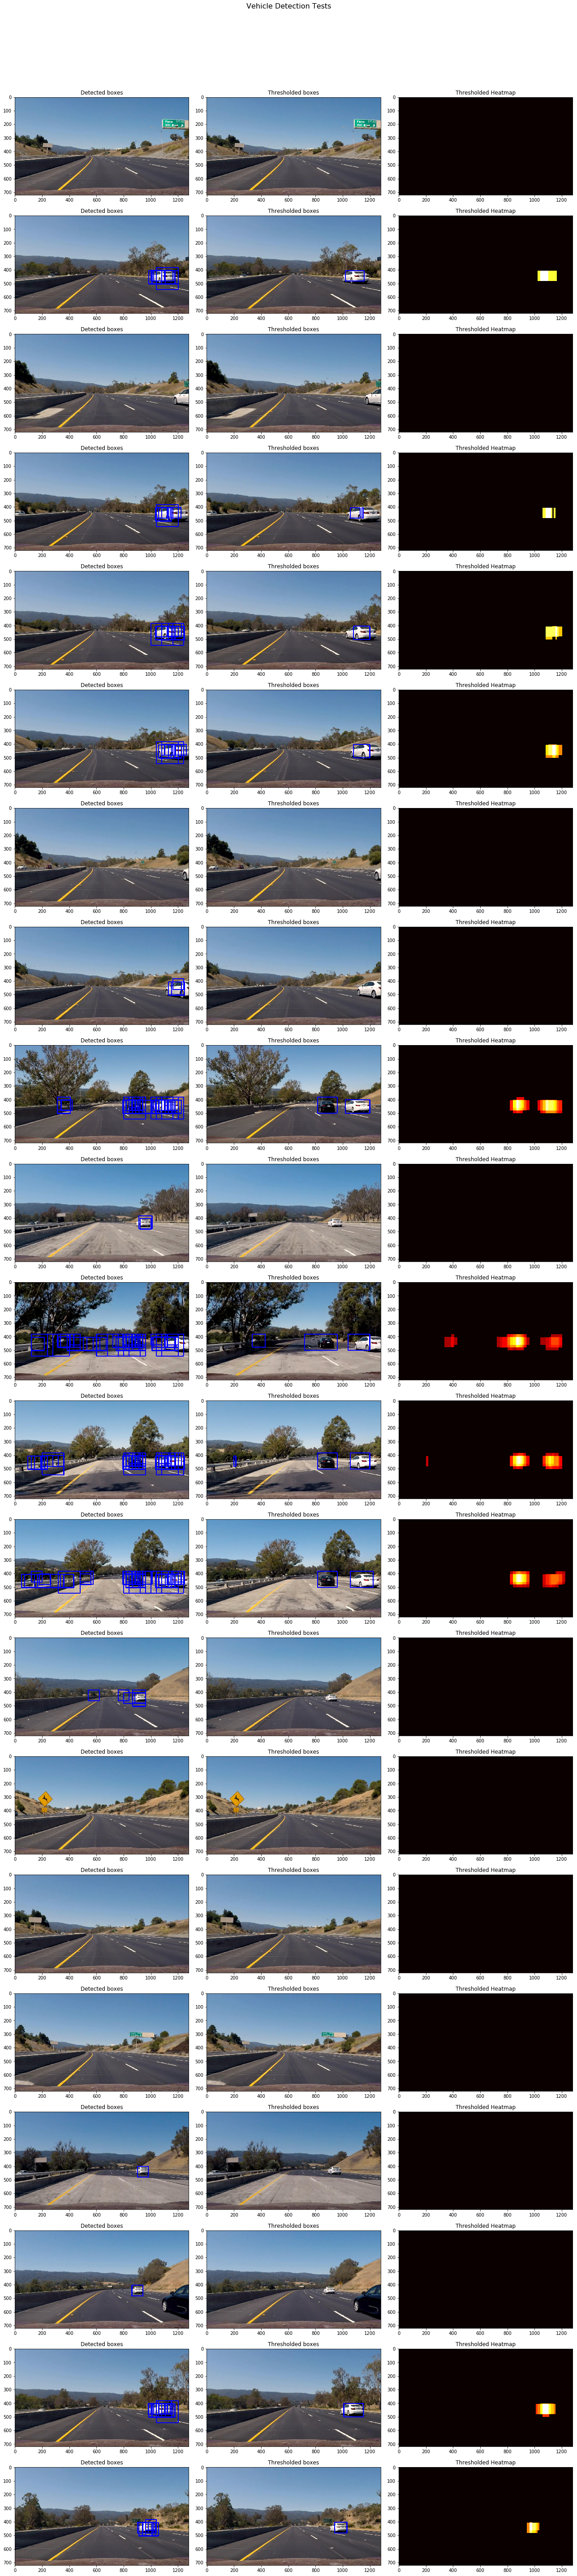

In [169]:
image_paths = glob.glob('./test_images/*.jpg')
vehicle_imgs = []
for image_path in image_paths:
    img = mpimg.imread(image_path)
    detection_results = find_vehicles(img, threshold=3, scales=[1.25, 1.5, 2.5], overlap=0.75)
    vehicle_imgs.append(detection_results)
    
plt_scale = 6
cols = 3
rows = len(vehicle_imgs)
pos = 1

fig = plt.figure(figsize=(plt_scale * cols, (plt_scale // 1.5) * rows))
fig.suptitle('Vehicle Detection Tests', fontsize=16)

for (img, heat_img, heatmap) in vehicle_imgs:
    canvas = fig.add_subplot(rows, cols, pos)
    canvas.set_title('Detected boxes')
    plt.imshow(img)
    pos +=1
    canvas = fig.add_subplot(rows, cols, pos)
    canvas.set_title('Thresholded boxes')
    plt.imshow(heat_img)
    pos +=1
    canvas = fig.add_subplot(rows, cols, pos)
    canvas.set_title('Thresholded Heatmap')
    plt.imshow(heatmap, cmap='hot')
    pos +=1

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Output video generation 

#### Process each video frame using code similar to `find_vehicles()`. Create a class `VehicleDetector()` that will help remember the heatmaps across multiple frames so that multiple frame heatmaps can be aggregated when making a prediction. Experiment with various values for number of frames and threshold. 

In [146]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class VehicleDetector(object):
    def __init__(self):
        self.n_frames = 5
        self.heatmaps = deque(maxlen = self.n_frames)
        self.threshold = 15
        self.frame_count = 0
    def __call__(self, img):
        self.frame_count += 1
        draw_img = np.copy(img)
        
        # Current frame heatmap
        heatmap = np.zeros_like(img[:,:,0])
        
        for scale in [1.25, 1.5, 2.5]:
            img_boxes, hmap, count = find_vehicle_boxes(img, scale=scale, overlap=0.75)
            heatmap += np.array(hmap)

        # Aggregate over last n frames
        self.heatmaps.append(heatmap)
        
        heatmap = np.sum(self.heatmaps, axis=0)
        
        # Apply threshold
        heatmap[heatmap <= self.threshold] = 0
        
        # Label and draw boxes
        labels = label(heatmap)
        
        draw_img = draw_labeled_bboxes(draw_img, labels)
        
        return draw_img

#### Generate test output video, inspect it. If there are too many false positives or false negatives, go back to `class VehicleDetector()` and make adjustments to the scales / number of frames to aggregate, and threshold. 

In [147]:
process_image = VehicleDetector()
project_video_output = 'output_videos/test_video.mp4'
clip = VideoFileClip("./test_video.mp4")
#clip = VideoFileClip("./project_video.mp4")
project_video_clip = clip.fl_image(process_image)
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 19.4 s, sys: 750 ms, total: 20.1 s
Wall time: 20.6 s


In [148]:
process_image = VehicleDetector()
project_video_output = 'output_videos/project_video.mp4'
#clip = VideoFileClip("./project_video.mp4").subclip(22,32)
clip = VideoFileClip("./project_video.mp4")
project_video_clip = clip.fl_image(process_image)
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [11:26<00:00,  1.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 11min 8s, sys: 25.9 s, total: 11min 34s
Wall time: 11min 27s
